2025-05-11 12:40:26.835 
  command:

    streamlit run C:\Users\starf\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-05-11 12:40:26.836 No runtime found, using MemoryCacheStorageManager
2025-05-11 12:40:26.839 No runtime found, using MemoryCacheStorageManager
2025-05-11 12:40:51.861 Session state does not function when running a script without `streamlit run`


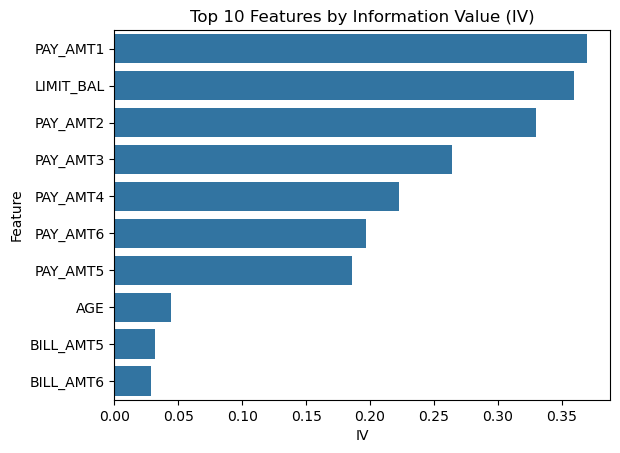

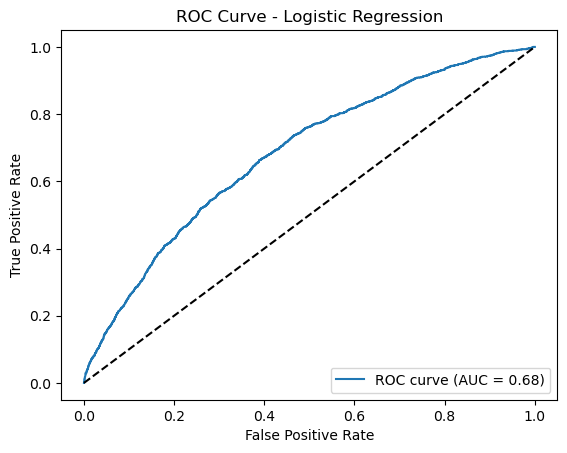

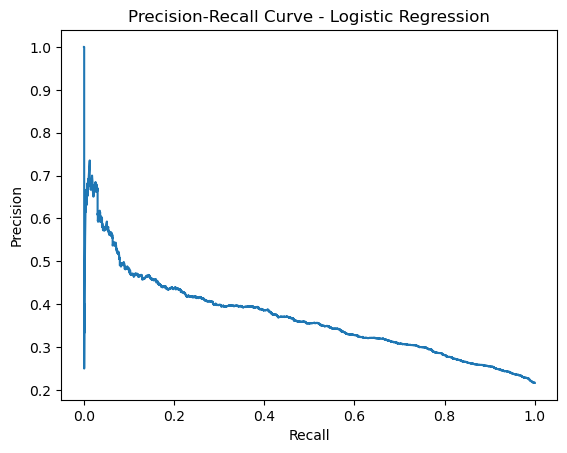

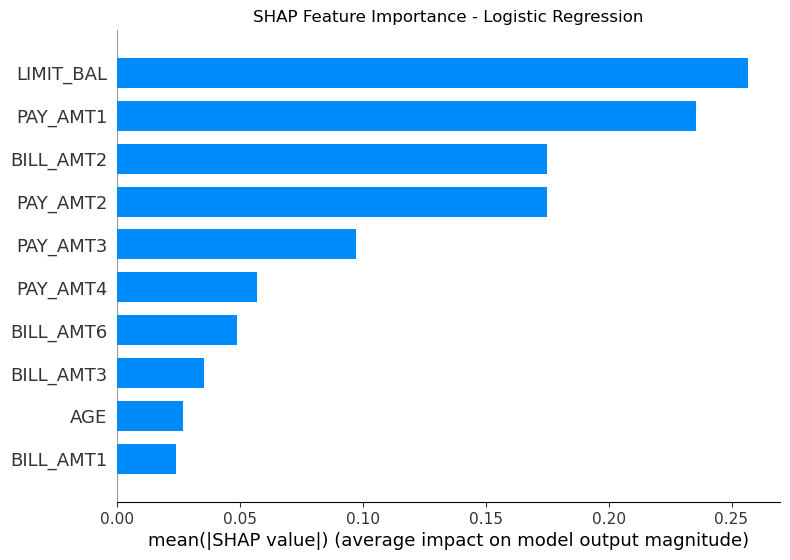

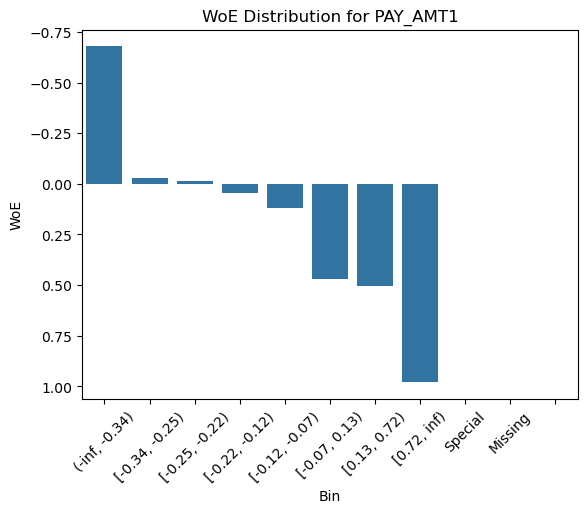

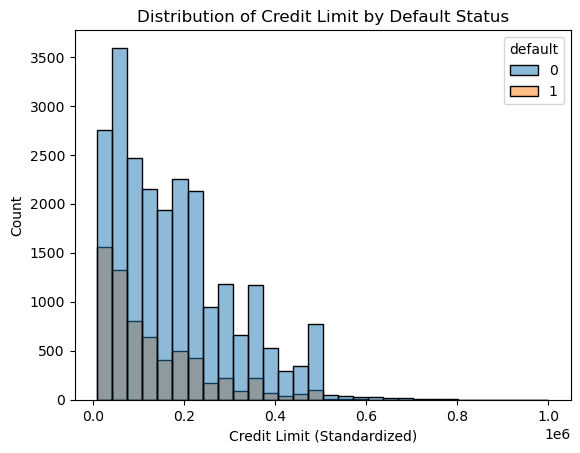

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import shap
from optbinning import OptimalBinning
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(123)

# Streamlit App Title
st.title("Credit Risk Management App")
st.markdown("""
This app uses a logistic regression model to predict credit default risk, incorporating Weight of Evidence (WoE), 
Information Value (IV), and SHAP for interpretability. The model is trained on the UCI Credit Card Default Dataset.
""")

# 1. Load and Preprocess the UCI Credit Card Default Dataset
@st.cache_data
def load_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
    df = pd.read_excel(url, header=1)
    df = df.rename(columns={'default payment next month': 'default'})
    df = df.drop(columns=['ID'])
    return df

df = load_data()
st.write("Dataset Loaded:", df.head())

# Define feature types
numerical_cols = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 
                  'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 
                  'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 
                    'PAY_4', 'PAY_5', 'PAY_6']

# Handle missing values
num_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# 2. WoE and IV Calculation
def calculate_woe_iv(df, feature, target):
    optb = OptimalBinning(name=feature, dtype="numerical" if df[feature].dtype in ['int64', 'float64'] else "categorical")
    try:
        optb.fit(df[feature].values, df[target].values)
        binning_table = optb.binning_table.build()
        iv = binning_table['IV'].sum()
        woe = binning_table[['Bin', 'WoE']].set_index('Bin').to_dict()['WoE']
        return woe, iv, optb
    except:
        return {}, 0, None

woe_dict = {}
iv_dict = {}
optb_dict = {}
features = [col for col in df_encoded.columns if col != 'default']
for feature in features:
    woe, iv, optb = calculate_woe_iv(df_encoded, feature, 'default')
    woe_dict[feature] = woe
    iv_dict[feature] = iv
    optb_dict[feature] = optb

# Lower IV threshold
iv_threshold = 0.01
selected_features = [f for f, iv in iv_dict.items() if iv > iv_threshold]
if not selected_features:
    st.warning("No features passed IV threshold. Using all features.")
    selected_features = features

# Transform features to WoE values
df_woe = df_encoded.copy()
for feature in selected_features:
    if optb_dict[feature] is not None:
        df_woe[feature] = optb_dict[feature].transform(df_woe[feature], metric="woe")
    else:
        df_woe = df_woe.drop(columns=[feature])
        selected_features.remove(feature)

# 3. Train-Test Split
X = df_woe[selected_features]
y = df_woe['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# 4. Model Training
# Logistic Regression
log_reg = LogisticRegression(random_state=123)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
y_pred_prob_log = log_reg.predict_proba(X_test)[:, 1]

# Linear Regression (Variant 1: WoE features)
lin_reg1 = LinearRegression()
lin_reg1.fit(X_train, y_train)
y_pred_lin1 = lin_reg1.predict(X_test)
y_pred_lin1 = np.clip(y_pred_lin1, 0, 1)

# Linear Regression (Variant 2: Raw features)
X_no_woe = df_encoded[selected_features]
X_train_no_woe, X_test_no_woe = train_test_split(X_no_woe, test_size=0.3, random_state=123)
lin_reg2 = LinearRegression()
lin_reg2.fit(X_train_no_woe, y_train)
y_pred_lin2 = lin_reg2.predict(X_test_no_woe)
y_pred_lin2 = np.clip(y_pred_lin2, 0, 1)

# 5. Prediction Interface
st.header("Predict Default Risk")
st.markdown("Enter client details to predict the probability of default.")

# Create input fields for a subset of key features
input_data = {}
with st.form("prediction_form"):
    input_data['LIMIT_BAL'] = st.slider("Credit Limit (LIMIT_BAL)", 10000, 1000000, 50000)
    input_data['AGE'] = st.slider("Age", 20, 80, 30)
    input_data['PAY_0'] = st.selectbox("Payment Status (PAY_0)", [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
    input_data['BILL_AMT1'] = st.slider("Bill Amount (BILL_AMT1)", 0, 500000, 10000)
    input_data['PAY_AMT1'] = st.slider("Payment Amount (PAY_AMT1)", 0, 500000, 5000)
    submitted = st.form_submit_button("Predict")

# Process input data and predict
if submitted:
    input_df = pd.DataFrame([input_data])
    input_df = pd.get_dummies(input_df)
    # Align input with training data columns
    for col in selected_features:
        if col not in input_df.columns:
            input_df[col] = 0
    input_df = input_df[selected_features]
    # Standardize numerical features
    input_df[numerical_cols] = scaler.transform(input_df[numerical_cols])
    # Apply WoE transformation
    for feature in selected_features:
        if feature in optb_dict and optb_dict[feature] is not None:
            input_df[feature] = optb_dict[feature].transform(input_df[feature], metric="woe")
    # Predict
    prob = log_reg.predict_proba(input_df)[:, 1][0]
    st.write(f"**Predicted Default Probability:** {prob:.2%}")
    if prob > 0.5:
        st.error("High risk of default!")
    else:
        st.success("Low risk of default.")

# 6. Display Model Performance and Visualizations
st.header("Model Performance and Insights")

# Logistic Regression Classification Report
st.subheader("Logistic Regression Performance")
st.text(classification_report(y_test, y_pred_log))

# Correlation for Linear Models
corr_lin1 = np.corrcoef(y_test, y_pred_lin1)[0, 1]
corr_lin2 = np.corrcoef(y_test, y_pred_lin2)[0, 1]
st.write("**Correlation with Actual Default:**")
st.write(f"Linear Regression (WoE Features): {corr_lin1:.3f}")
st.write(f"Linear Regression (Raw Features): {corr_lin2:.3f}")

# Visualizations
st.subheader("Visualizations")

# IV Bar Plot
fig, ax = plt.subplots()
iv_df = pd.DataFrame({'Feature': iv_dict.keys(), 'IV': iv_dict.values()})
iv_df = iv_df.sort_values('IV', ascending=False).head(10)
sns.barplot(x='IV', y='Feature', data=iv_df, ax=ax)
ax.set_title('Top 10 Features by Information Value (IV)')
st.pyplot(fig)

# ROC Curve
fig, ax = plt.subplots()
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_log)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Logistic Regression')
ax.legend(loc='lower right')
st.pyplot(fig)

# Precision-Recall Curve
fig, ax = plt.subplots()
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_log)
ax.plot(recall, precision)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve - Logistic Regression')
st.pyplot(fig)

# SHAP Feature Importance
fig, ax = plt.subplots()
explainer = shap.LinearExplainer(log_reg, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, show=False)
plt.title('SHAP Feature Importance - Logistic Regression')
st.pyplot(fig)

# WoE Distribution for Top Feature
fig, ax = plt.subplots()
top_feature = iv_df['Feature'].iloc[0]
if optb_dict[top_feature] is not None:
    binning_table = optb_dict[top_feature].binning_table.build()
    sns.barplot(x='Bin', y='WoE', data=binning_table, ax=ax)
    ax.set_title(f'WoE Distribution for {top_feature}')
    ax.tick_params(axis='x', rotation=45)
else:
    ax.text(0.5, 0.5, 'WoE not available for top feature', ha='center')
    ax.set_title(f'WoE Distribution for {top_feature}')
st.pyplot(fig)

# Distribution of Credit Limit
fig, ax = plt.subplots()
sns.histplot(data=df, x='LIMIT_BAL', hue='default', bins=30, ax=ax)
ax.set_title('Distribution of Credit Limit by Default Status')
ax.set_xlabel('Credit Limit (Standardized)')
ax.set_ylabel('Count')
st.pyplot(fig)

# Dataset Insights
st.subheader("Dataset Insights")
default_rate = df['default'].mean()
st.write(f"**Dataset Default Rate:** {default_rate:.3f} ({default_rate*100:.1f}%)")
st.write(f"**Number of Features Selected (IV > {iv_threshold}):** {len(selected_features)}")
st.write(f"**Total Features Analyzed:** {len(features)}")

# Feature Importance Tables
st.subheader("Feature Importance")
st.write("**Top 5 Features by IV:**")
st.write(iv_df.head(5)[['Feature', 'IV']])

st.write("**Top 5 Features by SHAP Importance:**")
shap_df = pd.DataFrame({
    'Feature': selected_features,
    'SHAP Importance': np.abs(shap_values).mean(axis=0)
}).sort_values('SHAP Importance', ascending=False).head(5)
st.write(shap_df)

In [3]:
!streamlit run C:\Users\starf\anaconda3\Lib\site-packages\ipykernel_launcher.py


^C
